In [19]:
%load_ext autoreload
%autoreload 2

import torch
import notebook_setup

device = torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

Define data distribution and take a sample

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from callbacks import UpdateProgressBarStats
from implicit.datasets import ProjectedNormal, MixtureDistribution
from visualization import plot_3d_points, plot_surface


dist = MixtureDistribution(
    components=(
        ProjectedNormal(concentration=(1., 0., 0.)),
        ProjectedNormal(concentration=(-1., 0., 0.)),
    ),
    weights=(0.5, 0.5)
)
points = dist.manifold_points(count=500)[0]

densities = dist.prob(points).numpy()
data = dist.sample(1000)

lims = {"xlims": (-1.1, 1.1), "ylims": (-1.1, 1.1), "zlims": (-1.03, 1.03)} # Set lims for each plot
ebm_lims = torch.Tensor((lims["xlims"], lims["ylims"], lims["zlims"])).T


dataloader = data.split(100)
callbacks = [UpdateProgressBarStats(loader=dataloader)]

In [21]:
import matplotlib.colors as mcolors
from matplotlib import cm

cmap_gnbu = cm.GnBu # default colormap
# darkened colormap
cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap_gnbu.name, a=0.2, b=1.0),
        cmap_gnbu(np.linspace(0.2, 1.0, 100)))

Plot ground truth

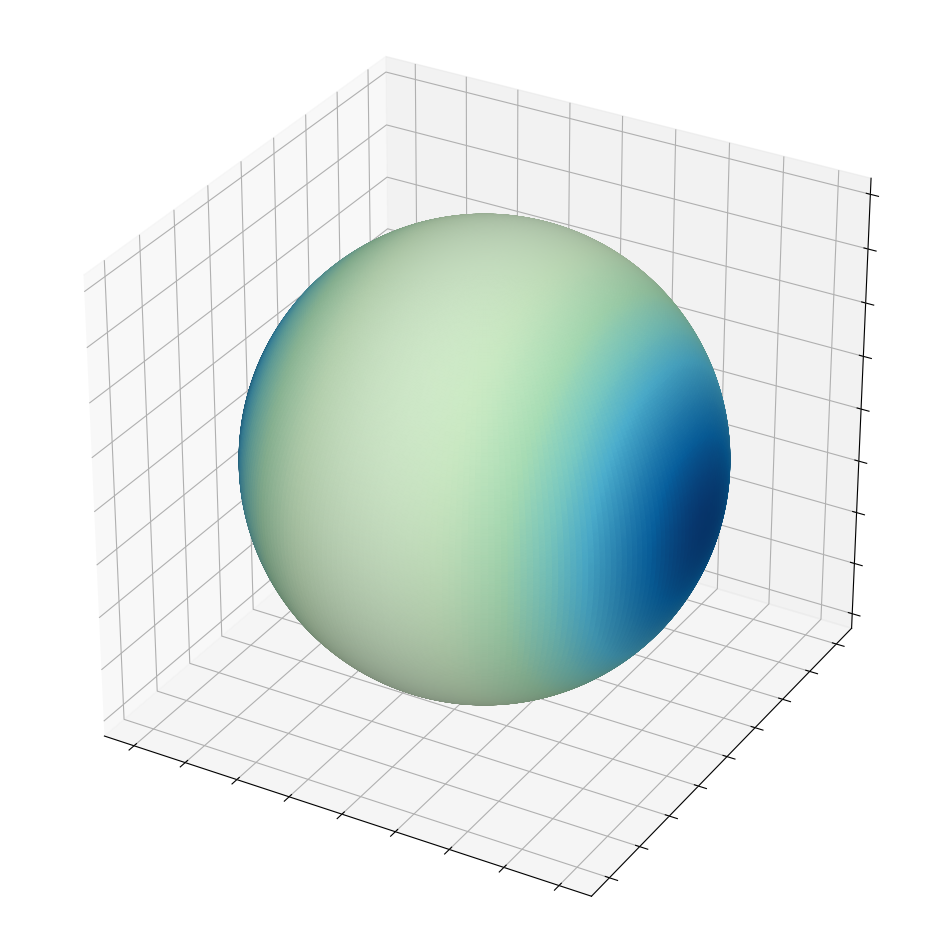

In [22]:
plot_surface(points, facecolors=densities, normalize_cols=True, cmap=cmap, **lims, equal_aspect=True, 
             lightsource=mcolors.LightSource(azdeg=140, altdeg=40))

# EBIM

Train an MDF

In [23]:
%%time
from torch import optim
from implicit.maps import FlatSmoothMap
from implicit.models.ebm import ImplicitManifold

mdf = FlatSmoothMap(3, 1, hidden_size=8)
manifold = ImplicitManifold(mdf, ebm_lims, device)
opt = optim.Adam(mdf.parameters(), lr=0.01)

manifold.train(
    optim=opt,
    dataloader=dataloader,
    epochs=300,
    neg_weight=0.3,
    mu=10.,
    sv_min=0.1,
    buffer_frac=0.95,
    mc_kwargs={
        "eps": 0.1,
        "alpha": 10,
    },
    callbacks=callbacks,
)

[E300] loss: -0.0112 | pos: 0.0038 | neg: 0.0892 | sv_min: 0.0000 | sv_max: 0.0000 | scale

CPU times: user 2min 11s, sys: 2.08 s, total: 2min 13s
Wall time: 2min 11s


In [24]:
from implicit.metrics import distance_to_implicit_manifold

implicit_dists = distance_to_implicit_manifold(data, manifold)
implicit_dists.min(), implicit_dists.median(), implicit_dists.mean(), implicit_dists.max()

(tensor(2.3870e-05), tensor(0.0077), tensor(0.0079), tensor(0.0181))

In [25]:
from implicit.models.ebm import ConstrainedEBM

energy = FlatSmoothMap(3, 1, num_layers=2, spectral_norm=False)
cebm = ConstrainedEBM(manifold, energy, lims=ebm_lims, device=device, 
                     line_search_fn="strong_wolfe", buffer_size=1000)

opt = optim.Adam(energy.parameters(), lr=0.01)

cebm.train(
    optim=opt,
    dataloader=dataloader, 
    epochs=20,
    beta=1.,
    clip_norm=1.,

    buffer_frac=0.95,
    noise_kwargs={
        "opt_steps": 1,
        "line_search_fn": "strong_wolfe",
    },
    mc_kwargs={
        "n_steps": 10,
        "eps": 0.3,
        "alpha": None,
        "grad_clamp": 0.03,
        "opt_steps": 1,
        "line_search_fn": "strong_wolfe"
    },
    callbacks=callbacks,
)

[E 20] loss: 0.0032 | scale_loss: 0.0262: 100%|███████████| 20/20 [02:15<00:00,  6.79s/it]


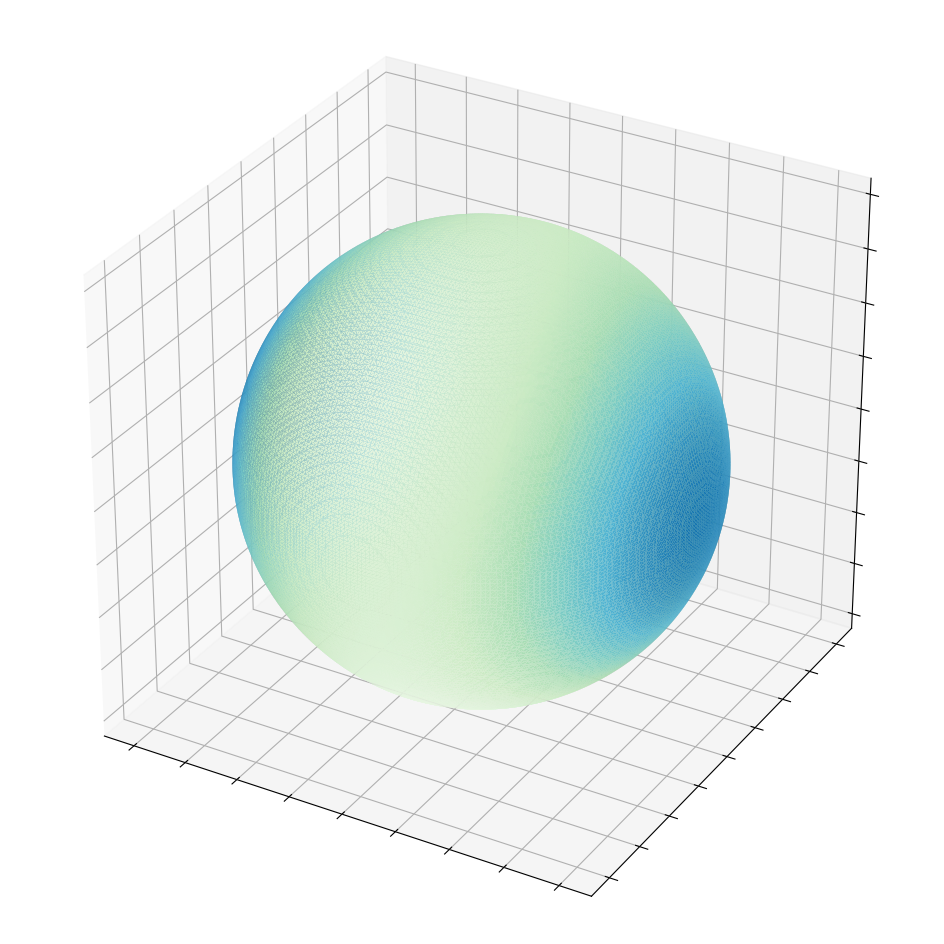

In [28]:
from visualization import plot_mdf_surface

uniform_points = ProjectedNormal(concentration=(0., 0., 0.)).sample(1000)
mc_partition = torch.exp(-energy(uniform_points)).squeeze().mean() * 4 * np.pi

density_func = lambda x: torch.exp(-energy(x)).squeeze() / mc_partition
plot_mdf_surface(mdf, density_func, **lims, equal_aspect=True)

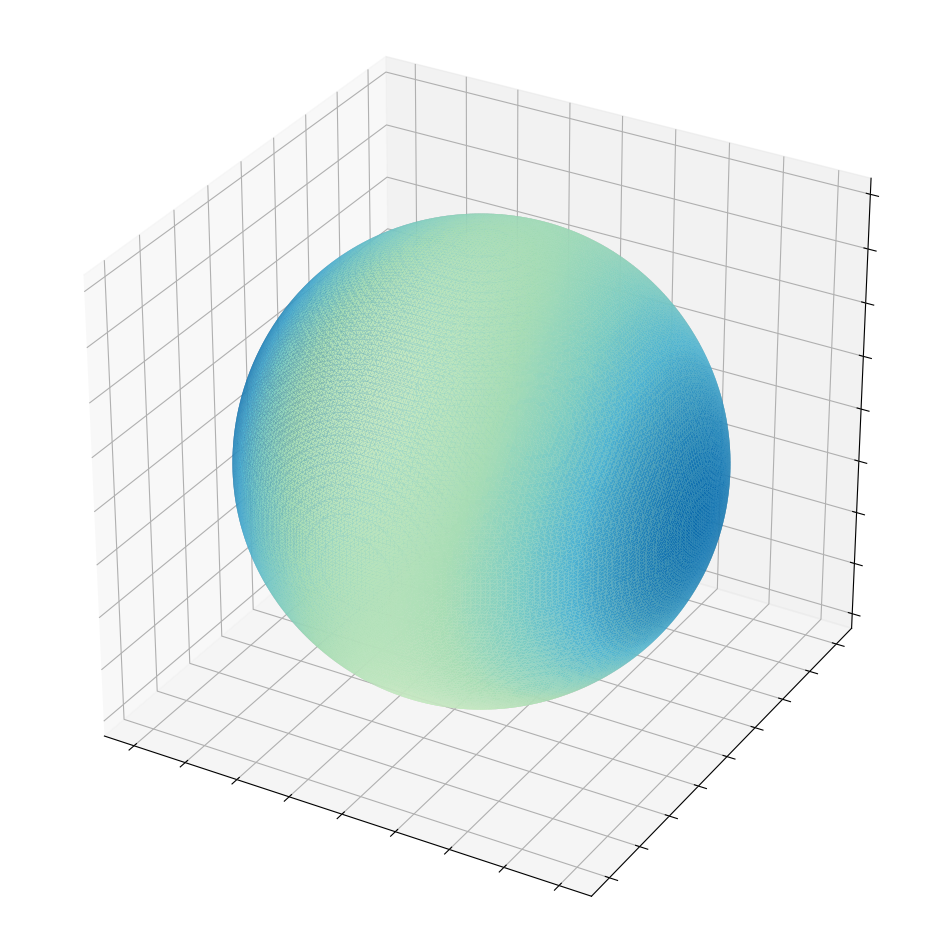

In [27]:
from visualization import plot_mdf_surface

uniform_points = ProjectedNormal(concentration=(0., 0., 0.)).sample(1000)
mc_partition = torch.exp(-energy(uniform_points)).squeeze().mean() * 4 * np.pi

density_func = lambda x: torch.exp(-energy(x)).squeeze() / mc_partition
plot_mdf_surface(mdf, density_func, cmap=cmap, **lims, equal_aspect=True)

## Manifold Arithmetic

In [30]:
def rshift(x, shift=0.5):
    return x - torch.Tensor((-shift, 0, 0))

def lshift(x, shift=0.5):
    return x - torch.Tensor((shift, 0, 0))

def left_mdf(x):
    return mdf(rshift(x))
    
def left_energy(x):
    return energy(rshift(x))

def right_mdf(x):
    return mdf(lshift(x))
    
def right_energy(x):
    return energy(lshift(x))

def int_mdf(x):        
    return torch.cat((left_mdf(x), right_mdf(x)))

def int_energy(x):
    return left_energy(x) + right_energy(x)

def union_mdf(x):
    return left_mdf(x) * right_mdf(x)

def mixture_density(x):
    ldensity = torch.exp(-left_energy(x)).squeeze() / mc_partition
    rdensity = torch.exp(-right_energy(x)).squeeze() / mc_partition
    
    zero = torch.zeros(x.shape[:-1])
    return torch.where(
        left_mdf(x).squeeze() < right_mdf(x).squeeze(),
        0.5*ldensity,
        0.5*rdensity,
    )

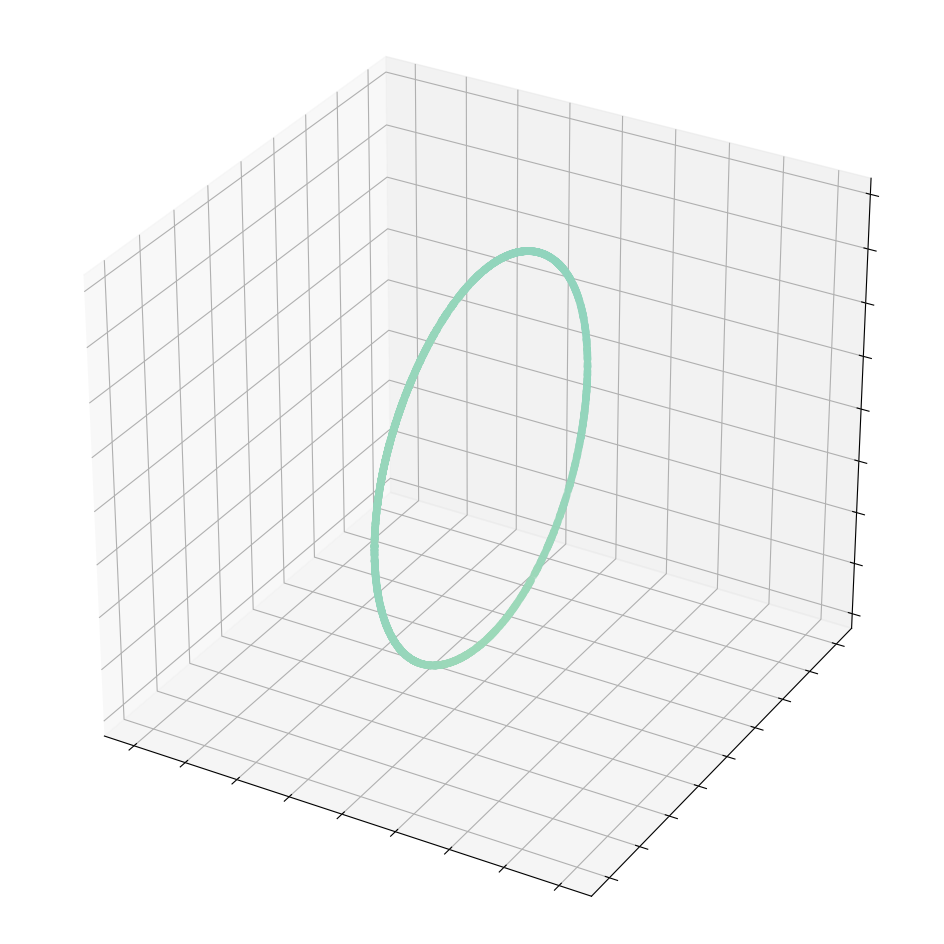

In [31]:
from implicit.models.ebm import EBM

class IntManifold:
    mdf = int_mdf

ambient_noise = EBM.sample_noise(cebm, 3000)
manifold_noise = ImplicitManifold.project(IntManifold, ambient_noise, opt_steps=10)
manifold_noise = cebm._clamp(manifold_noise)

with torch.no_grad():
    densities = torch.exp(-int_energy(manifold_noise)).squeeze() / 5

plot_3d_points(manifold_noise, c=densities, **lims, darken=0.25, equal_aspect=True)

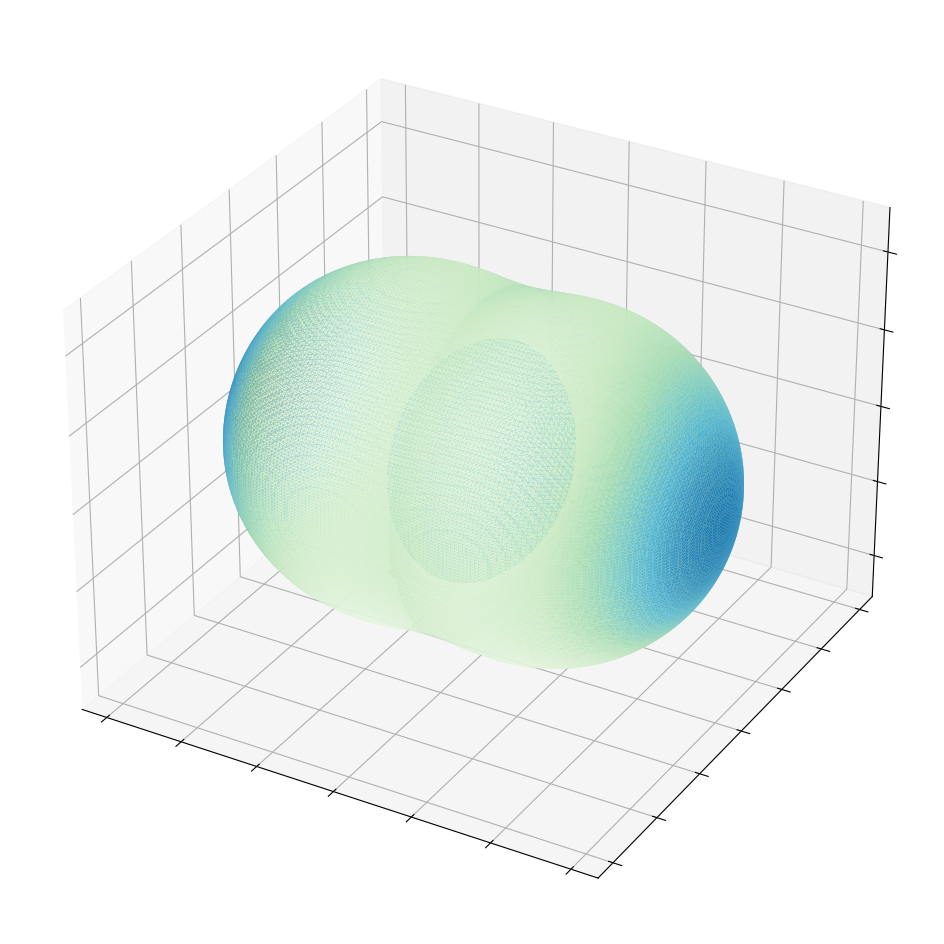

In [32]:
plot_mdf_surface(union_mdf, mixture_density, xlims=(-1.6, 1.6), ylims=(-1.6, 1.6), zlims=(-1.23, 1.23), 
                 equal_aspect=True)

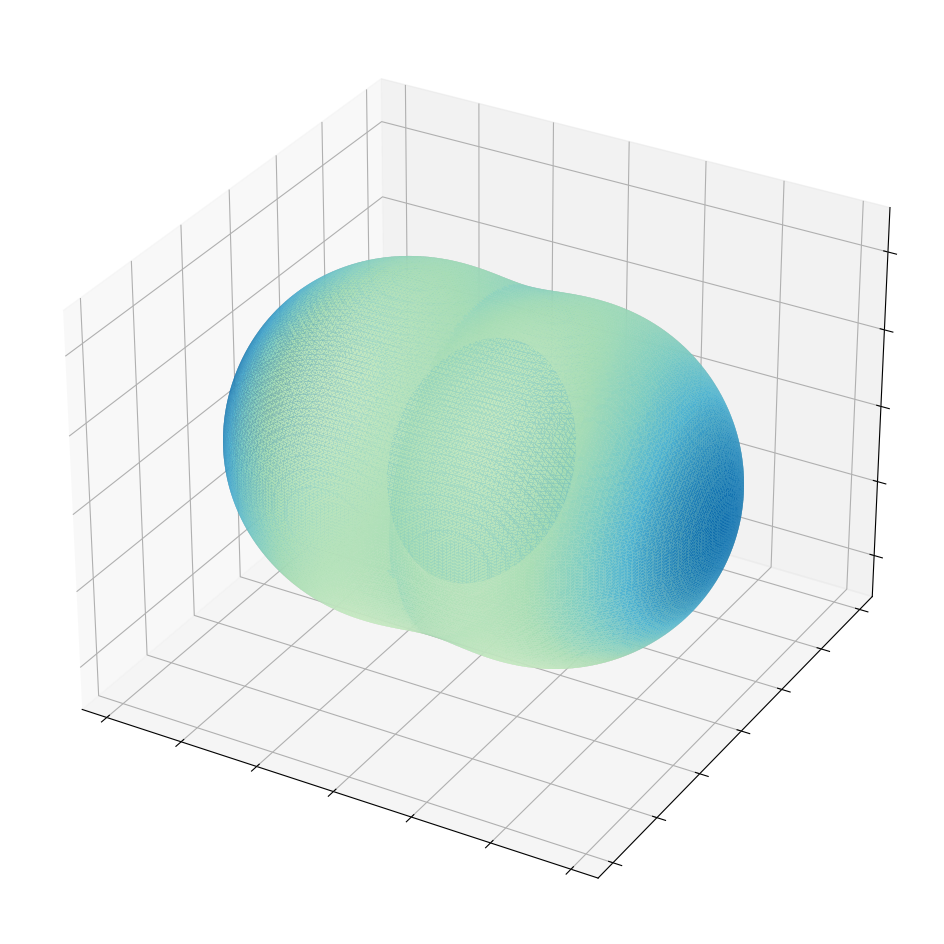

In [33]:
plot_mdf_surface(union_mdf, mixture_density, xlims=(-1.6, 1.6), ylims=(-1.6, 1.6), zlims=(-1.23, 1.23), 
                 cmap=cmap, equal_aspect=True)